In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
from torchvision.datasets.utils import download_url
import tarfile
import torchvision.datasets as datasets
import os
from tqdm import tqdm
import seaborn
import matplotlib.pyplot as plt

In [183]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  
    transforms.ToTensor(),  
])


In [184]:
dataset = datasets.ImageFolder(root='dataset', transform=transform)


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


class_names = dataset.classes
class_names


['Beagle',
 'Boxer',
 'Bulldog',
 'Dachshund',
 'German_Shepherd',
 'Golden_Retriever',
 'Labrador_Retriever',
 'Poodle',
 'Rottweiler',
 'Yorkshire_Terrier']

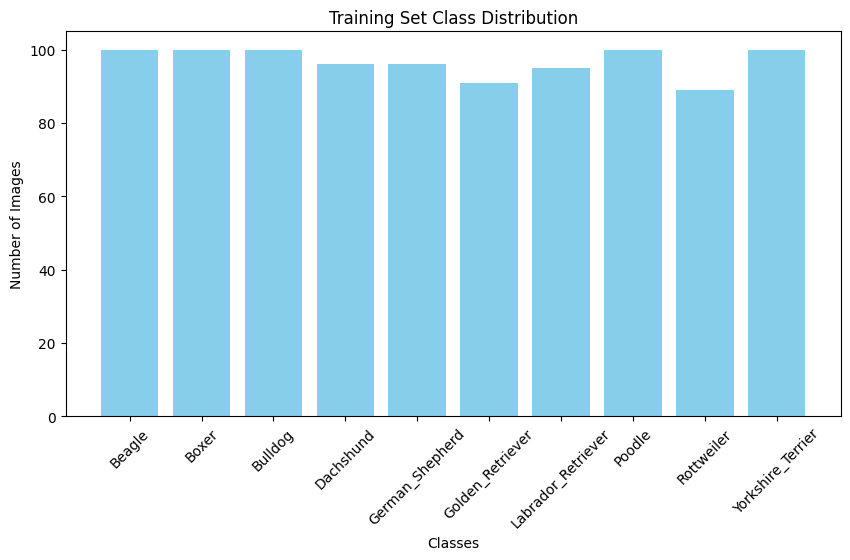

Class counts: {'Beagle': 100, 'Boxer': 100, 'Bulldog': 100, 'Dachshund': 96, 'German_Shepherd': 96, 'Golden_Retriever': 91, 'Labrador_Retriever': 95, 'Poodle': 100, 'Rottweiler': 89, 'Yorkshire_Terrier': 100}


In [4]:
import os 

def count_images_per_class(dataset_path):
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_class_counts = count_images_per_class('dataset')

def plot_class_distribution(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_class_counts, 'Training Set Class Distribution')
print("Class counts:", train_class_counts)

In [211]:
num_classes = len(dataset.classes)
img, label = dataset[0]
img_shape = img.shape
img_size = img_shape[-1]
(num_classes, img_size)

(10, 32)

In [186]:
import matplotlib.pyplot as plt
%matplotlib inline

In [187]:
import random
def show_example():
    int = random.randint(0, len(dataset)-1)
    img, label = dataset[int]
    plt.imshow(img.permute(1,2,0))
    print("Label: " , dataset.classes[label] + " ["+str(label)+"]")

Label:  German_Shepherd [4]


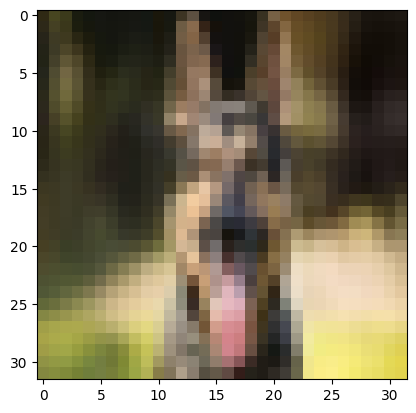

In [188]:
show_example()

In [189]:
batch_size = 128


train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=128, shuffle=False)

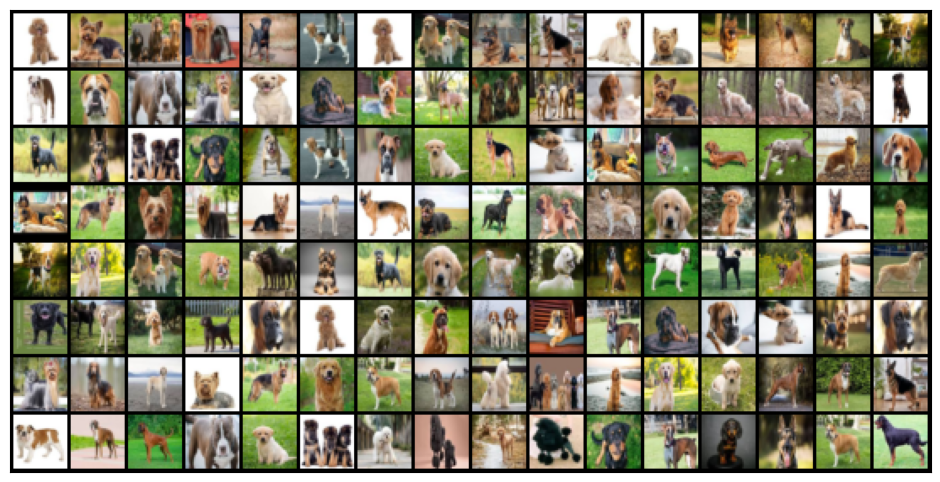

In [190]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_dl)


In [191]:
class CNN(nn.Module):
    def __init__(self,num_classes,img_size):
        super(CNN,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64,kernel_size = 3, padding = 1),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2), #img_size by 2
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2), #img_size by 4
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.LeakyReLU(negative_slope=0.01, inplace=False),
            nn.MaxPool2d(kernel_size=2,stride=2), #img_size by 8
         )
        self.classifier = nn.Sequential(
            nn.Linear(256*(img_size//8)*(img_size//8),512),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Linear(512,num_classes)
        )
        
    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x

In [192]:
model = CNN(num_classes,img_size)

In [193]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [194]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [195]:
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [197]:
import matplotlib.pyplot as plt

def train(train_loader, model, criterion, optimizer, num_epochs):
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        total_loss = 0.0
        train_loader = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            total_loss += loss.item()
        
        epoch_loss = total_loss / len(train_loader)
        epoch_acc = total_correct / total_samples * 100
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%')

    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
    plt.title('Training accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.show()

Epoch [1/25], Train Loss: 2.3109, Train Accuracy: 12.29%


Epoch [2/25], Train Loss: 2.2956, Train Accuracy: 9.83%


Epoch [3/25], Train Loss: 2.2020, Train Accuracy: 18.63%


Epoch [4/25], Train Loss: 2.0390, Train Accuracy: 24.58%


Epoch [5/25], Train Loss: 1.8974, Train Accuracy: 31.31%


Epoch [6/25], Train Loss: 1.8434, Train Accuracy: 30.92%


Epoch [7/25], Train Loss: 1.5486, Train Accuracy: 44.24%


Epoch [8/25], Train Loss: 1.4468, Train Accuracy: 49.42%


Epoch [9/25], Train Loss: 1.1825, Train Accuracy: 57.83%


Epoch [10/25], Train Loss: 0.9962, Train Accuracy: 65.59%


Epoch [11/25], Train Loss: 0.8269, Train Accuracy: 70.63%


Epoch [12/25], Train Loss: 0.5976, Train Accuracy: 78.65%


Epoch [13/25], Train Loss: 0.4848, Train Accuracy: 86.42%


Epoch [14/25], Train Loss: 0.3336, Train Accuracy: 90.17%


Epoch [15/25], Train Loss: 0.1790, Train Accuracy: 95.99%


Epoch [16/25], Train Loss: 0.1281, Train Accuracy: 97.02%


Epoch [17/25], Train Loss: 0.1075, Train Accuracy: 97.15%


Epoch [18/25], Train Loss: 0.0429, Train Accuracy: 99.48%


Epoch [19/25], Train Loss: 0.0384, Train Accuracy: 99.74%


Epoch [20/25], Train Loss: 0.0256, Train Accuracy: 99.35%


Epoch [21/25], Train Loss: 0.0144, Train Accuracy: 99.87%


Epoch [22/25], Train Loss: 0.0086, Train Accuracy: 99.87%


Epoch [23/25], Train Loss: 0.0077, Train Accuracy: 99.74%


Epoch [24/25], Train Loss: 0.0050, Train Accuracy: 99.87%


Epoch [25/25], Train Loss: 0.0020, Train Accuracy: 100.00%


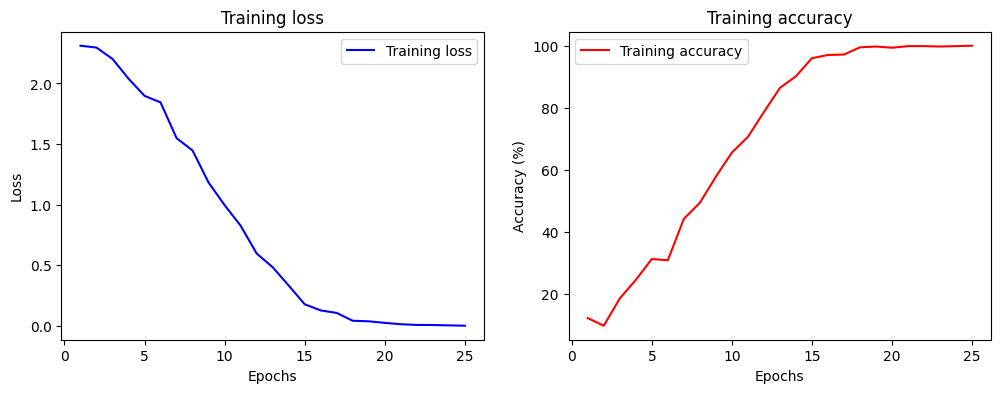

In [198]:
train(train_dl, model, criterion, optimizer, num_epochs=25)


In [199]:
torch.save(model.state_dict(), 'Dog_Classifier.pth')


In [200]:
PATH = 'Dog_Classifier.pth'
state = {'model': model.state_dict()}
torch.save(state, PATH)
model.load_state_dict(torch.load(PATH)['model'])
for k, v in model.named_parameters():
    print(k, v)

features.0.weight Parameter containing:
tensor([[[[-1.2508e-01,  1.7702e-01,  1.2121e-02],
          [ 1.2455e-01,  1.8241e-01, -5.0361e-02],
          [ 6.8069e-02,  2.2207e-02, -3.5153e-02]],

         [[-3.3787e-02, -1.6299e-02, -2.5780e-02],
          [-1.6932e-01, -6.0414e-02,  6.8387e-02],
          [-1.4028e-01,  5.5644e-02, -2.2583e-02]],

         [[-1.6175e-01, -1.3863e-01, -5.8427e-02],
          [-2.0020e-02,  1.2129e-01,  4.6802e-02],
          [ 1.1701e-01,  1.9179e-01,  2.1904e-01]]],


        [[[ 1.3574e-01,  9.7971e-02, -1.4733e-01],
          [ 6.7273e-03,  1.3837e-01, -7.8698e-03],
          [ 8.8454e-02, -4.7155e-02, -5.5754e-02]],

         [[ 8.0875e-02,  7.1105e-02,  8.0308e-02],
          [ 9.1051e-02, -1.6833e-01,  1.7987e-01],
          [-2.4093e-02, -5.9142e-02,  6.0746e-02]],

         [[-6.7210e-02, -1.1688e-01, -9.1188e-04],
          [ 1.1115e-01, -4.6556e-02,  1.3932e-01],
          [ 2.2922e-02, -1.8407e-01,  1.5867e-01]]],


        [[[ 4.5608e-02, -7

Accuracy: 1.00


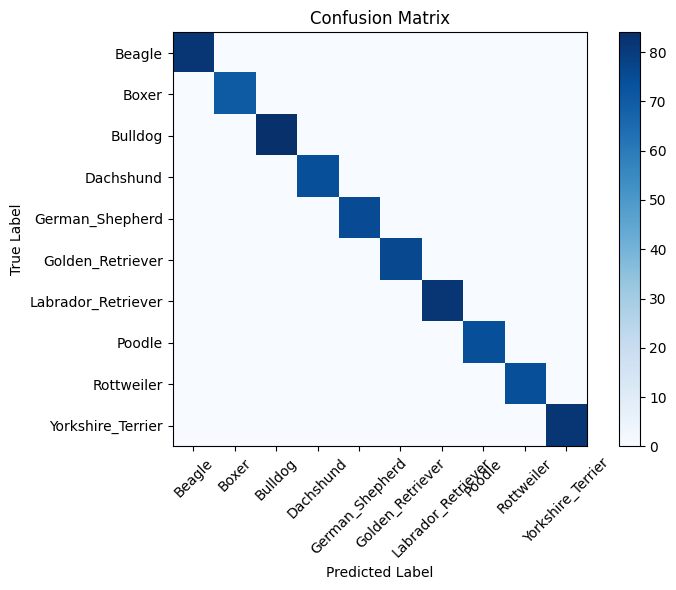

                    precision    recall  f1-score   support

            Beagle       1.00      1.00      1.00        82
             Boxer       1.00      1.00      1.00        70
           Bulldog       1.00      1.00      1.00        84
         Dachshund       1.00      1.00      1.00        74
   German_Shepherd       1.00      1.00      1.00        75
  Golden_Retriever       1.00      1.00      1.00        76
Labrador_Retriever       1.00      1.00      1.00        82
            Poodle       1.00      1.00      1.00        74
        Rottweiler       1.00      1.00      1.00        74
 Yorkshire_Terrier       1.00      1.00      1.00        82

          accuracy                           1.00       773
         macro avg       1.00      1.00      1.00       773
      weighted avg       1.00      1.00      1.00       773



In [201]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)
accuracy = np.mean(predictions == true_labels)
print(f'Accuracy: {accuracy:.2f}')

class_names = dataset.classes
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print(classification_report(true_labels, predictions, target_names=class_names))


Testing Accuracy: 1.00


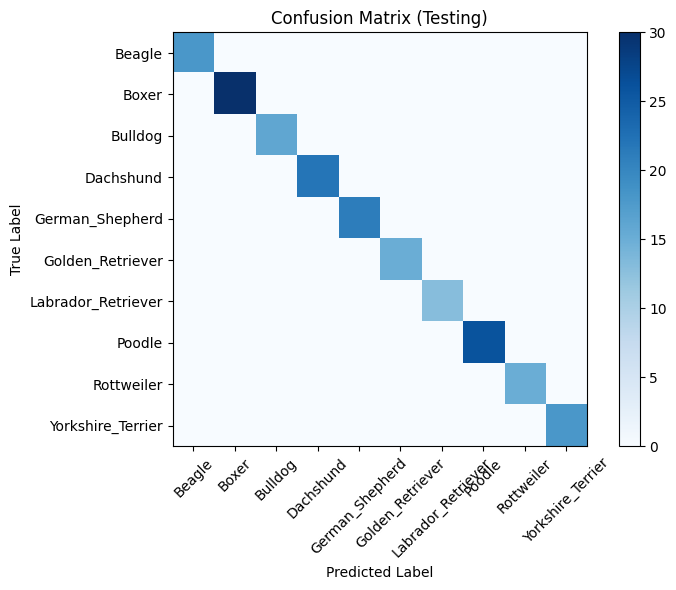

                    precision    recall  f1-score   support

            Beagle       1.00      1.00      1.00        18
             Boxer       1.00      1.00      1.00        30
           Bulldog       1.00      1.00      1.00        16
         Dachshund       1.00      1.00      1.00        22
   German_Shepherd       1.00      1.00      1.00        21
  Golden_Retriever       1.00      1.00      1.00        15
Labrador_Retriever       1.00      1.00      1.00        13
            Poodle       1.00      1.00      1.00        26
        Rottweiler       1.00      1.00      1.00        15
 Yorkshire_Terrier       1.00      1.00      1.00        18

          accuracy                           1.00       194
         macro avg       1.00      1.00      1.00       194
      weighted avg       1.00      1.00      1.00       194



In [202]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)
accuracy = np.mean(predictions == true_labels)
print(f'Testing Accuracy: {accuracy:.2f}')

conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Testing)')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print(classification_report(true_labels, predictions, target_names=class_names))


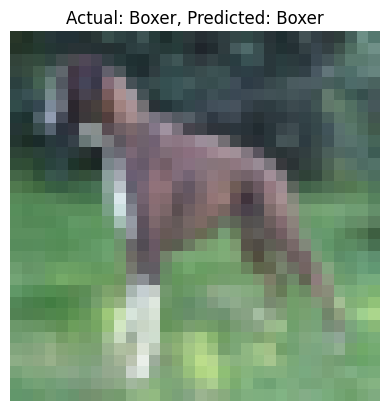

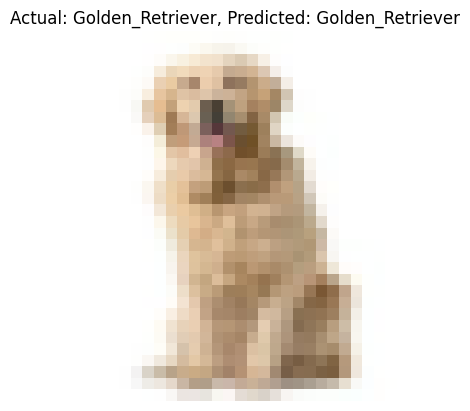

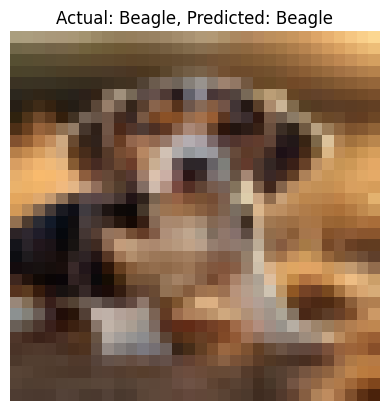

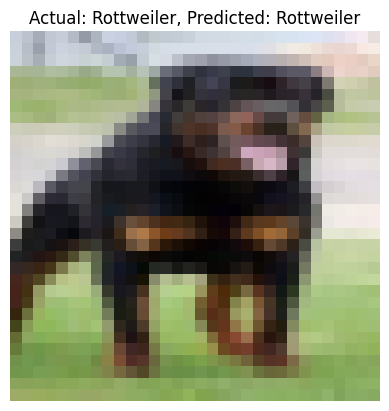

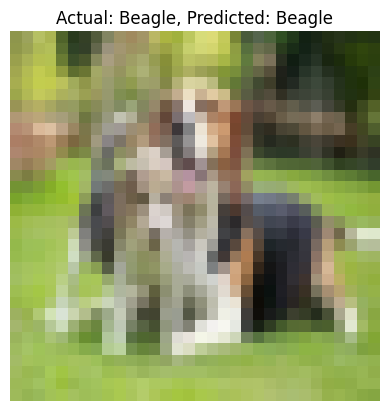

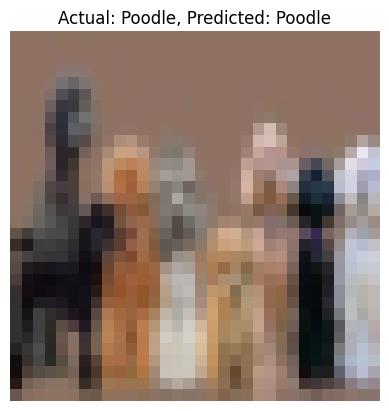

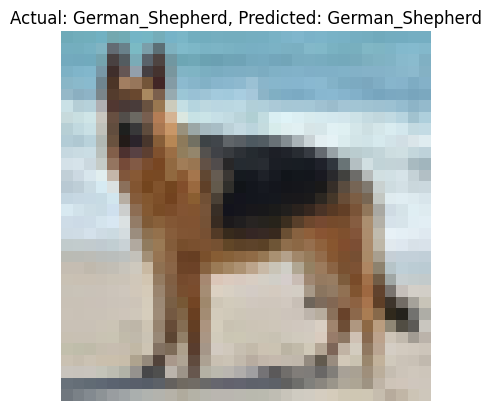

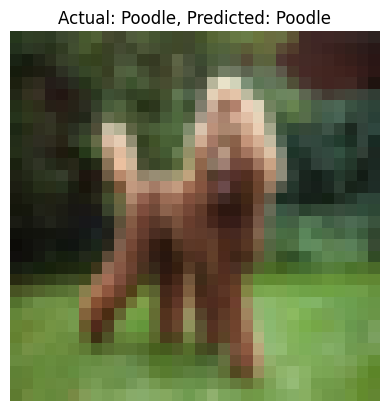

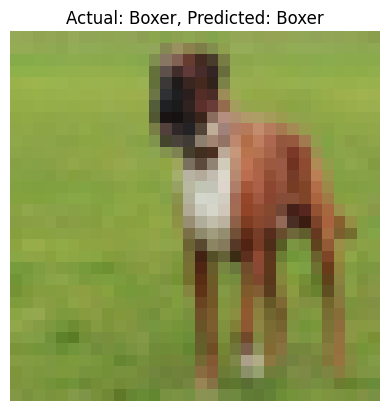

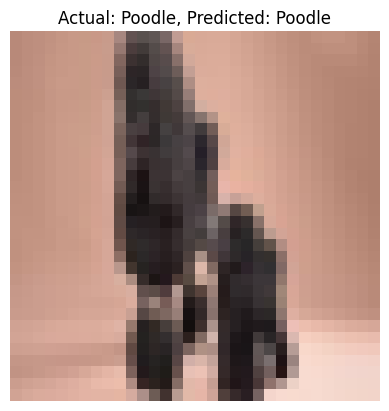

In [203]:
def imshow(img, title):
    npimg = img.cpu().numpy() 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

indices = np.random.randint(0, len(test_dataset), size=10)
random_images = [test_dataset[i] for i in indices]

images = torch.stack([img for img, _ in random_images])
labels = [label for _, label in random_images]

images = images.to(device)

with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

predicted = predicted.tolist()
labels = [dataset.classes[label] for label in labels]
predicted_labels = [dataset.classes[label] for label in predicted]

for i in range(10):
    imshow(images[i], f'Actual: {labels[i]}, Predicted: {predicted_labels[i]}')


In [204]:
from PIL import Image
import torch
import torchvision.transforms as transforms

def predict_image_class(image_path, model, class_names):
    image_path = "images/" + image_path
    entered_image = Image.open(image_path)

    
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ])

    transformed_image = transform(entered_image).unsqueeze(0)  

    
    model.eval()

    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transformed_image = transformed_image.to(device)

    
    with torch.no_grad():
        outputs = model(transformed_image)

    
    _, predicted = torch.max(outputs, 1)
    predicted_class = predicted.item()  

    
    probs = torch.softmax(outputs, dim=1)
    predicted_prob = probs[0, predicted_class].item()

    print(f'Predicted Class: {class_names[predicted_class]}, Probability: {predicted_prob:.2f}')
    
    plt.imshow(entered_image)
    plt.show()


Predicted Class: Rottweiler, Probability: 0.89


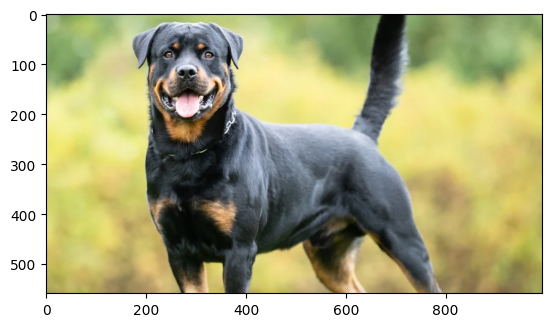

In [205]:
predict_image_class('img1.jpg', model, class_names)

Predicted Class: German_Shepherd, Probability: 1.00


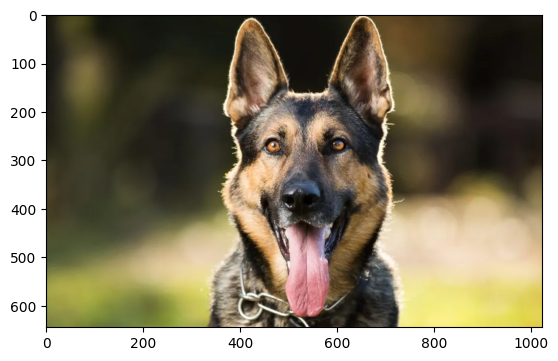

In [206]:
predict_image_class('img2.jpg', model, class_names)

Predicted Class: Dachshund, Probability: 1.00


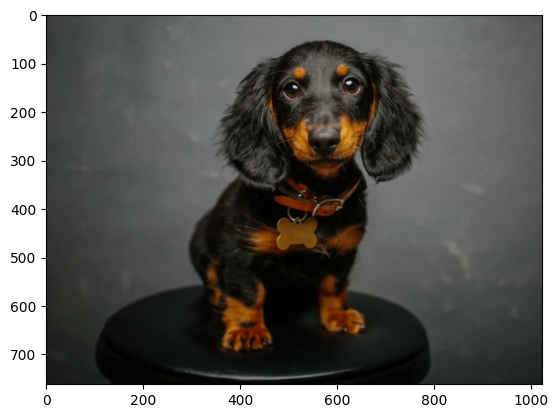

In [209]:
predict_image_class('img3.jpg', model, class_names)

Predicted Class: Beagle, Probability: 0.69


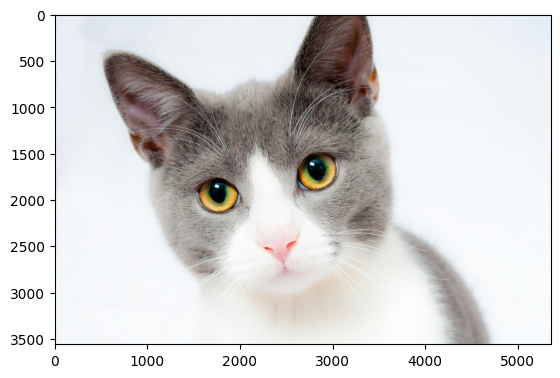

In [208]:
predict_image_class('cat.jpg', model, class_names)